## Analysis of ChatGPT length limitations

ChatGPT can hallucinate measurement techniques when the length of the name+description provided to it are not long enough. These hallucinations can be very high quality and difficult to distinguish from reasonable predictions (They will even map to measurementTechnique ontology terms with high scores). While ChatGPT's performance is more likely to be word-dependent, it is hard to develop heuristics based on the terms themselves, so we'll just use a length-based heuristic to limit the hallucinations

In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
script_path = os.getcwd()
data_path = os.path.join(script_path,'data')
data_file = os.path.join(data_path,'GPT Measurement Techniques Word Count Samples.tsv')
data_file2 = os.path.join(data_path,'GPT measurementTechnique - Harvard_Mendeley_Zenodo.tsv')
data = pd.read_csv(data_file2,delimiter='\t',header=0)
print(data.head(n=2))

result_path = os.path.join(script_path,'result')

                            _id         Repository Word Count Range  \
0  Dataverse_10.7910_DVN_UMKWCI  Harvard Dataverse       0-10 words   
1  Dataverse_10.7910_DVN_CJDNIE  Harvard Dataverse       0-10 words   

                                                Name  \
0  Konzeptstudie über die Kompatibilität von Regi...   
1                                      A13_24998.jpg   

                                         Description          Model  \
0                                                  I  gpt-3.5-turbo   
1  Link to OCHRE database: http://pi.lib.uchicago...  gpt-3.5-turbo   

                                         Predictions  # correct  
0  ['Conceptual study', 'Compatibility analysis',...          2  
1              ['Image capture', 'Database linking']          0  


In [3]:
def count_predictions(a_prediction):
    if "', '" in a_prediction:
        tmp = a_prediction.replace("', '","|")
        splitlist = tmp.split("|")
        counts = len(splitlist)
    else:
        counts = 1
    return counts 

def get_word_count(row):
    if row['Name']==None:
        namelist = []
    elif isinstance(row['Name'],float):
        namelist = []
    elif " " in row['Name']:
        namelist = row['Name'].split(" ")
    else:
        namelist = [row['Name']]
    if row['Description']==None:
        desclist = []
    elif isinstance(row['Description'],float):
        desclist = []
    elif " " in row['Description']:
        desclist = row['Description'].split(" ")
    else:
        desclist = [row['Description']]
    wordcount = len(namelist)+len(desclist)
    return wordcount

def get_char_count(row):
    namechars = len(str(row['Name']))
    descchars = len(str(row['Description']))
    char_count = namechars+descchars
    return char_count

In [4]:
data['# of predictions'] = data.apply(lambda row: count_predictions(row['Predictions']), axis=1)
data['words'] = data.apply(lambda row: get_word_count(row), axis=1)
data['chars'] = data.apply(lambda row: get_char_count(row), axis=1)

print(data.head(n=2))
data.to_csv(os.path.join(data_path,'length_check_to_review_HarMenZen.tsv'),sep='\t',header=True)

                            _id         Repository Word Count Range  \
0  Dataverse_10.7910_DVN_UMKWCI  Harvard Dataverse       0-10 words   
1  Dataverse_10.7910_DVN_CJDNIE  Harvard Dataverse       0-10 words   

                                                Name  \
0  Konzeptstudie über die Kompatibilität von Regi...   
1                                      A13_24998.jpg   

                                         Description          Model  \
0                                                  I  gpt-3.5-turbo   
1  Link to OCHRE database: http://pi.lib.uchicago...  gpt-3.5-turbo   

                                         Predictions  # correct  \
0  ['Conceptual study', 'Compatibility analysis',...          2   
1              ['Image capture', 'Database linking']          0   

   # of predictions  words  chars  
0                 4     10     86  
1                 2      6    115  


## Analyze the reviewed data

In [24]:
evaluation_file = os.path.join(data_path,'measTech count evaluations.tsv')
evaluation_file2 = os.path.join(data_path,'length_check_to_review_HarMenZen.tsv')
evaluations = pd.read_csv(evaluation_file,delimiter='\t',header=0)
evaluations2 = pd.read_csv(evaluation_file2,delimiter='\t',header=0)
evaluations2.rename(columns={'Word Count Range':'Number of Words'},inplace=True)

all_evals = pd.concat((evaluations,evaluations2),ignore_index=True)
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("20-Nov","11-20")
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("10 or less","0-10")
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("0-10 words","0-10")
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("11-20 words","11-20")
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("21-30 words","21-30")
all_evals['Number of Words'] = all_evals['Number of Words'].astype(str).str.replace("31-40 words","31-40")
all_evals.drop(['% Hallucinations','Unnamed: 0'],axis=1,inplace=True)
print(all_evals.head(n=2))

                            _id                                       Name  \
0  Dataverse_10.7910_DVN_BA39BT                             hou02665c01004   
1                   PRJNA428424  Lactiplantibacillus plantarum strain:IRG1   

                                         Description          Model  \
0                                                  L  gpt-3.5-turbo   
1  Lactobacillus plantarum IRG1 Genome sequencing...  gpt-3.5-turbo   

                        Repository Number of Words  \
0                Harvard Dataverse            0-10   
1  Omics Discovery Index (OmicsDI)            0-10   

                                         Predictions  # of predictions  words  \
0  {'Laser-induced breakdown spectroscopy (LIBS)'...                 3      2   
1                  {'Genome sequencing', 'Assembly'}                 2     10   

   chars  # correct  
0     15          0  
1    100          2  


In [16]:
def add_calcs(df):
    df['% true'] = df['# correct']/df['# of predictions']
    df['% Hallucinations'] = 1-df['% true']
    return df

def add_bins(binlist,df,bintype):
    df['bin'] = pd.cut(df[bintype], binlist)
    return df

def generate_stats(df,factorlist):
    dfA = df.groupby(factorlist)['% Hallucinations'].mean().reset_index(name='avg hallucinations')
    dfB = df.groupby(factorlist)['words'].mean().reset_index(name='avg words')
    dfC = df.groupby(factorlist)['chars'].mean().reset_index(name='avg chars')
    dfD = df.groupby(factorlist)['% true'].mean().reset_index(name='avg true')
    dfE = df.groupby(factorlist).size().reset_index(name='counts')
    alldf = dfA.merge(dfB.merge(dfC.merge(dfD.merge(dfE,on=factorlist,how='outer'),on=factorlist,how='outer'),on=factorlist,how='outer'),on=factorlist,how='outer')
    return alldf

In [25]:
all_evals = add_calcs(all_evals)
by_word_count = all_evals.groupby('words')['% Hallucinations'].mean()
by_char_count = all_evals.groupby('chars')['% Hallucinations'].mean()
print(by_char_count)

chars
15     1.000000
23     0.666667
29     1.000000
30     0.666667
31     0.000000
         ...   
314    0.000000
342    1.000000
343    0.333333
345    0.333333
351    0.333333
Name: % Hallucinations, Length: 118, dtype: float64


In [26]:
char_bins = [0,50,100,150,200,250,300]
dfbinned = add_bins(char_bins,all_evals,'chars')
print(dfbinned.head(n=2))

                            _id                                       Name  \
0  Dataverse_10.7910_DVN_BA39BT                             hou02665c01004   
1                   PRJNA428424  Lactiplantibacillus plantarum strain:IRG1   

                                         Description          Model  \
0                                                  L  gpt-3.5-turbo   
1  Lactobacillus plantarum IRG1 Genome sequencing...  gpt-3.5-turbo   

                        Repository Number of Words  \
0                Harvard Dataverse            0-10   
1  Omics Discovery Index (OmicsDI)            0-10   

                                         Predictions  # of predictions  words  \
0  {'Laser-induced breakdown spectroscopy (LIBS)'...                 3      2   
1                  {'Genome sequencing', 'Assembly'}                 2     10   

   chars  # correct  % true  % Hallucinations        bin  
0     15          0     0.0               1.0    (0, 50]  
1    100          2     1.

In [27]:
factorlist = ['Repository','Number of Words']
#factorlist = ['Repository','bin']
#factorlist = ['bin']
#factorlist = ['Repository']
alldf = generate_stats(all_evals,factorlist)
print(alldf)

alldf.to_csv(os.path.join(result_path,f"length_stats_by_{_.join(factorlist)}.tsv"),sep='\t',header=True)

                         Repository Number of Words  avg hallucinations  \
0                 Harvard Dataverse            0-10            0.928571   
1                 Harvard Dataverse           11-20            0.750000   
2                 Harvard Dataverse           21-30            1.000000   
3                 Harvard Dataverse           31-40            0.694444   
4                          Mendeley            0-10            0.800000   
5                          Mendeley           11-20            0.920635   
6                          Mendeley           21-30            0.633333   
7                          Mendeley           31-40            0.629630   
8                          NCBI GEO           31-40            0.583333   
9                          NCBI SRA            0-10            0.616667   
10                         NCBI SRA           11-20            0.375000   
11                         NCBI SRA           21-30            0.383333   
12                       

In [19]:
#by_repositoryA = evaluations.groupby('Repository')['% Hallucinations'].mean().reset_index(name='avg hallucinations')
#by_repositoryB = evaluations.groupby('Repository')['words'].mean().reset_index(name='avg words')
#by_repositoryC = evaluations.groupby('Repository')['chars'].mean().reset_index(name='avg chars')
#by_repositoryD = evaluations.groupby('Repository')['% true'].mean().reset_index(name='avg true')
#by_repositoryE = evaluations.groupby('Repository').size().reset_index(name='counts')

by_repositoryA = evaluations.groupby(['Repository','Number of Words'])['% Hallucinations'].mean().reset_index(name='avg hallucinations')
by_repositoryB = evaluations.groupby(['Repository','Number of Words'])['words'].mean().reset_index(name='avg words')
by_repositoryC = evaluations.groupby(['Repository','Number of Words'])['chars'].mean().reset_index(name='avg chars')
by_repositoryD = evaluations.groupby(['Repository','Number of Words'])['% true'].mean().reset_index(name='avg true')
by_repositoryE = evaluations.groupby(['Repository','Number of Words']).size().reset_index(name='counts')

#all_info = by_repositoryA.merge(by_repositoryB.merge(by_repositoryC.merge(by_repositoryD.merge(by_repositoryE,on=['Repository'],how='outer'),on=['Repository'],how='outer'),on=['Repository'],how='outer'),on=['Repository'],how='outer')
all_info = by_repositoryA.merge(by_repositoryB.merge(by_repositoryC.merge(by_repositoryD.merge(by_repositoryE,on=['Repository','Number of Words'],how='outer'),on=['Repository','Number of Words'],how='outer'),on=['Repository','Number of Words'],how='outer'),on=['Repository','Number of Words'],how='outer')

print(all_info)

                         Repository Number of Words  avg hallucinations  \
0                 Harvard Dataverse      10 or less            1.000000   
1                 Harvard Dataverse           11-20            1.000000   
2                 Harvard Dataverse           31-40            0.750000   
3                          Mendeley           11-20            0.857143   
4                          Mendeley           21-30            0.000000   
5                          Mendeley           31-40            0.500000   
6                          NCBI GEO           31-40            0.583333   
7                          NCBI SRA      10 or less            0.616667   
8                          NCBI SRA           11-20            0.375000   
9                          NCBI SRA           21-30            0.383333   
10                         NCBI SRA           31-40            0.433333   
11  Omics Discovery Index (OmicsDI)      10 or less            0.294444   
12  Omics Discovery Index

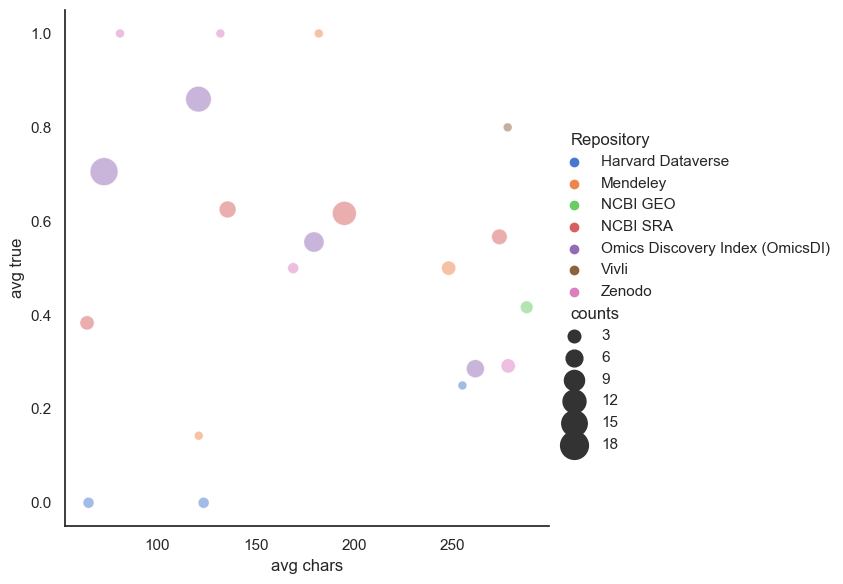

In [20]:
sns.set_theme(style="white")

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="avg chars", y="avg true", hue="Repository", size="counts",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=all_info)